#### Option 2: Loading image data with a custom `Dataset`

1. Be able to load images from files
2. Be able to get class names from the Dataset
3. Be able to get classes as dictionary (key < str>: value < int>) from the Dataset

Pros:
* Can create a `Dataset` out of almost anything
* Not limited to PyTorch pre-built `Dataset` functions

Cons:
* Even though you could create a `Dataset` out of almost anything, it doesn't mean it will work...
* Using a custom `Dataset` often results in us writing more code, which could be time wasting, prone to errors, or leads to performance issues

All custom datasets in PyTorch, often inherit from the `Dataset` class.

In [1]:
import os
import pathlib
import torch
from PIL import Image
from torchvision import transforms
from typing import List, Tuple, Dict

In [2]:
os.getcwd()

'/home/arp/Documents/github/ml-pytorch'

In [3]:
# create a helper function to get the class names
# we can use `os.scandir` to traverse a directory (ideally the directory is in standard image
# classification format)
# raise error if class names are not found (could be due wrong dir structure)
# turn the class names into a list and a dictionary

In [4]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """Finds the class folders in a dataset.

  Assumes the directory structure is the following:
  * data/
    * dataset_name/
      * train/
        * class 1/
        * class 2/
        * ...
      * test/
        * class 1/
        * class 2/
        * ...

  Args:
    directory (str): directory where the dataset is stored

  Returns:
    Tuple[List[str], Dict[str, int]]: (classes, class_to_idx)
      classes (List[str]): list of class names
      class_to_idx (Dict[str, int]): dictionary with class names as keys  and class indices as values
  """
  
  classes = sorted([entry.name for entry in os.scandir(directory) if entry.is_dir()])
  
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
  
  class_to_idx = { class_name: i for i, class_name in enumerate(classes)}
  
  return classes, class_to_idx

In [5]:
target_dir = "./data/pizza_steak_sushi"

find_classes(target_dir + "/train")

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

#### Create a custom `Dataset` to replicate `ImageFolder`

To create our own custom dataset, we wnt to:

1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory (the directory we'd like to get data from) as well as a transform if we'd like to transform our data.
3. Create several attributes:
    * paths - paths of our images
    * tansforms - the transform we'd like to use
    * classes - a list of the target classes
    * class_to_idx - a dictionary of the target classes mapped to integer labels
4. Create a function to `load_images()`, this function will open an image
5. Overwrite the `__len__()` (length) and `__getitem__()` (return a given sample when passed an index) methods

In [6]:
from torch.utils.data import Dataset

class ImageFolder(Dataset):
  def __init__(self, root: str, transform=None):
    self.paths = list(pathlib.Path(root).glob("**/*.jpg"))
    self.transform = transform
    self.classes, self.class_to_idx = find_classes(root)
  
  def load_image(self, index: int) -> Image.Image:
    """Opens an image via a path and returns it.

    Args:
      index (int): index of the image to be loaded from self.paths

    Returns:
      Image.Image: Image object
    """
    image = Image.open(self.paths[index])
    return image
  
  def __len__(self) -> int:
    return len(self.paths)
  
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    image = self.load_image(index)
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]
    
    if self.transform:
      image = self.transform(image)

    return image, class_idx

In [7]:
train_transform = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.RandomHorizontalFlip(0.5),
  transforms.ToTensor(),
])

test_transform = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.ToTensor(),
])



In [8]:
train_data = ImageFolder(target_dir + "/train", transform=train_transform)
test_data = ImageFolder(target_dir + "/test", transform=test_transform)
train_data, test_data

(<__main__.ImageFolder at 0x78da00ee4d70>,
 <__main__.ImageFolder at 0x78d9f372a690>)

In [9]:
len(train_data), len(test_data)

(225, 75)

In [10]:
train_data.classes

['pizza', 'steak', 'sushi']

In [11]:
train_data.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

#### Create a helper function to visualize data

1. Take in a `Dataset` and a number of other parameters such as class names and how many images to visualize.
2. To prevent the display getting out of hand, let's cap the number of images to see at 10.
3. Set the random seed for reproducibility
4. Get a list of random samples indexes from the target dataset
5. setup a matplotlib figure
6. Loop through the random sample images and plot them

In [12]:
range(len(train_data))

range(0, 225)

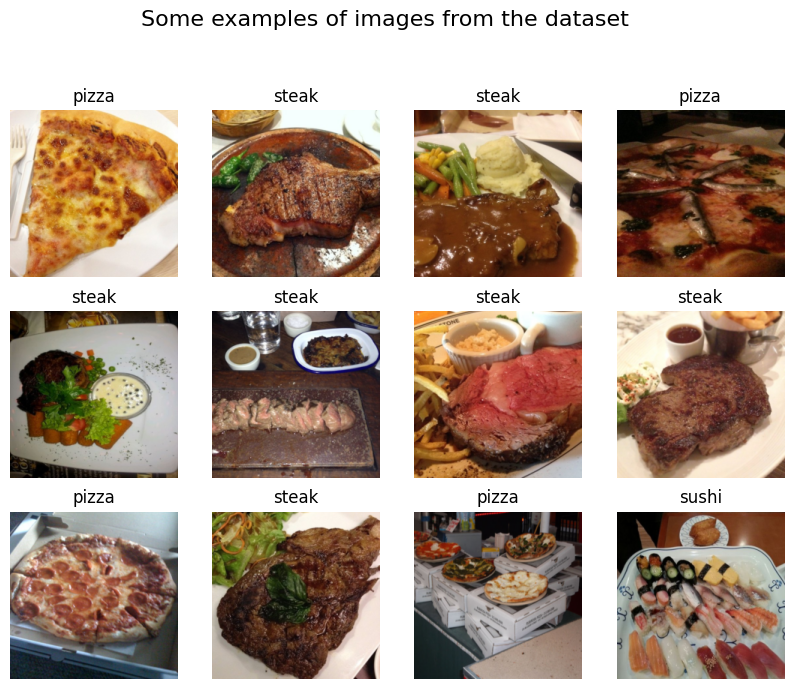

In [13]:
import matplotlib.pyplot as plt
import random

def display_examples(data: Dataset, classes: List[str], n: int, seed: int = 42):
  random.seed(seed)
  random_samples = random.sample(range(len(data)), n)
  fig = plt.figure(figsize=(10, 10))
  fig.suptitle("Some examples of images from the dataset", fontsize=16)
  for i, img_idx in enumerate(random_samples):
    img, class_idx = data[img_idx]
    ax = fig.add_subplot(4, 4, i + 1)
    ax.axis(False)
    ax.imshow(img.permute(1, 2, 0)) # [1st] -> img index, [2nd] -> img tensor
    ax.set_title(classes[class_idx])

display_examples(train_data, train_data.classes, 12)

In [14]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=os.cpu_count())
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x78d9e5ecdb50>,
 <torch.utils.data.dataloader.DataLoader at 0x78d9e6d8a030>)

In [15]:
batch, batch_labels = next(iter(train_dataloader))
batch.shape, batch_labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

#### 6. other forms of augmentation

Data augmentation is the process of artificially adding diversity to your training data.

In the case of image data, this may mean applying various image transformations to the training images.

examples:
- Rotation
- Flipping
- Adding noise
- Resizing
- Zooming
- etc

This practice hopefully results in a model that's more generalizable to unseen data.

Check data augmentation with [torchvision.transforms](https://pytorch.org/vision/stable/transforms.html)
[Blog post](https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/)


In [16]:
# Let's look at trivial augmente - https://pytorch.org/vision/stable/auto_examples/plot_transforms_getting_started.html

train_transform2 = transforms.Compose([
  transforms.Resize(224),
  transforms.TrivialAugmentWide(num_magnitude_bins=31), # check trivial augment
  transforms.ToTensor(),
])

test_transform2 = transforms.Compose([
  transforms.Resize(224),
  transforms.ToTensor(),
])

In [17]:
# Get all image paths
image_path_list = list(pathlib.Path(target_dir).glob("**/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/train/steak/3727491.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/443210.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1761285.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/482022.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2614649.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/256592.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/3577618.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/914570.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/231296.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2561199.jpg')]

In [18]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
  """
  Plots `n` random images from `image_paths`

  Args:
    image_paths (list): List of target image paths
    transform (PyTorch Transforms): image transformation
    n (int, optional): Total number of images to plot
    seed (int, optional): Random seed
  """
  random.seed(seed)
  # random image path
  random_image_path = random.sample(image_paths, n)
  for image in random_image_path:
    # open image
    with Image.open(image) as img:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(img)
      ax[0].set_title(f"Original\nSize: {img.size}")
      ax[0].axis(False)
      transformed_image = transform(img)
      
      ax[1].imshow(transformed_image.permute(1, 2, 0))
      ax[1].set_title(f"Transformed\nSize: {tuple(transformed_image.shape[1:])}")
      ax[1].axis(False)
      
      fig.suptitle(f"Class: {image.parent.stem}", fontsize=12)
      fig.tight_layout()

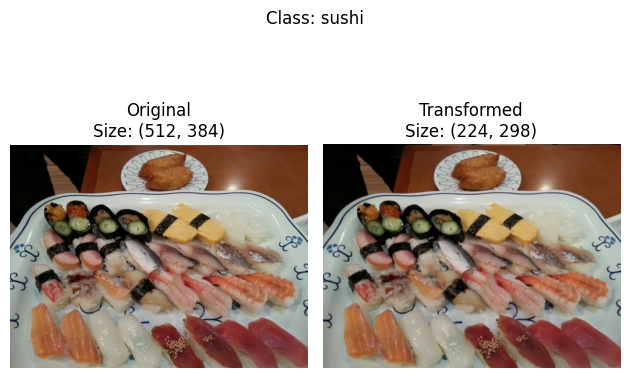

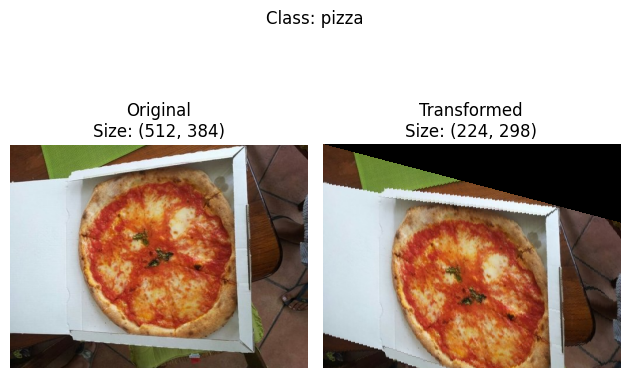

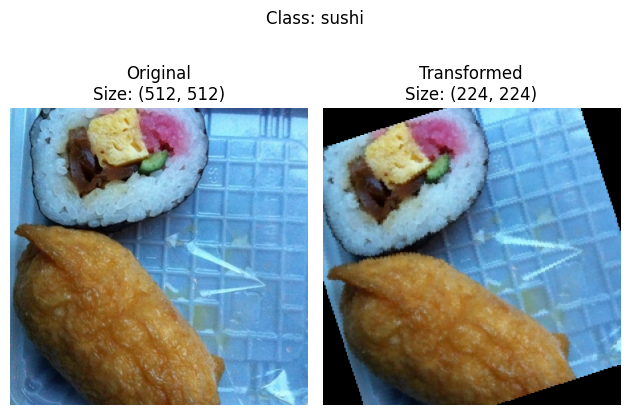

In [19]:
plot_transformed_images(
  image_paths=image_path_list,
  transform=train_transform2,
  n=3,
  seed=45
)

#### 7. Create a tinyVGG model without data augmentation

We'll replicate tinyVGG architecture from CNN Explainer [website](https://poloclub.github.io/cnn-explainer/)

In [20]:
simple_transform = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.ToTensor(),
])

In [21]:
from torchvision import datasets

train_data_simple = datasets.ImageFolder(root= target_dir + "/train", transform=simple_transform)
test_data_simple = datasets.ImageFolder(root= target_dir + "/test", transform=simple_transform)

import os
from torch.utils.data import DataLoader

train_dataloader_simple = DataLoader(train_data_simple, batch_size=32, shuffle=True, num_workers=os.cpu_count())
test_dataloader_simple = DataLoader(test_data_simple, batch_size=32, shuffle=False, num_workers=os.cpu_count())

len(train_dataloader_simple), len(test_dataloader_simple)

(8, 3)

In [91]:
from torch import nn

class TinyVGG(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13, out_features=output_shape)
    )
    
  def forward(self, x: torch.Tensor):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    return x # use operator fusion for faster computation (no need to save all intermediate outputs to "x")
    # return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [92]:
torch.manual_seed(42)
model = TinyVGG(input_shape=3, hidden_units=10, output_shape=len(train_data_simple.classes))
model

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [24]:
# try a forward pass on a single image batch (to test the model)

image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [93]:
model(image_batch)
# RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x2560 and 10x3)
# 10x3 is the in_features in nn.Linear (the 10 needs to match 2560)
# 32 -> batch size
# 2560 -> hidden_units after flatten
# 10 -> output shape
# 3 -> input shape

tensor([[ 2.0885e-02, -4.0333e-03,  1.1070e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4965e-03],
        [ 2.1457e-02, -1.8470e-03,  7.7899e-03],
        [ 2.0329e-02, -2.7594e-03,  9.1032e-03],
        [ 1.9547e-02, -1.1828e-03,  1.1937e-02],
        [ 1.7633e-02, -1.7809e-03,  7.5869e-03],
        [ 1.9826e-02, -3.8645e-03,  9.8465e-03],
        [ 2.0641e-02, -3.2445e-03,  7.5635e-03],
        [ 2.2108e-02, -2.7410e-04,  6.3588e-03],
        [ 1.8574e-02, -4.1228e-03,  1.0566e-02],
        [ 2.1909e-02, -4.9545e-03,  9.4220e-03],
        [ 2.1925e-02, -7.6100e-04,  1.0494e-02],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 2.2926e-02, -1.4961e-03,  1.0282e-02],
        [ 1.9832e-02, -1.3674e-03,  1.1364e-02],
        [ 2.1985e-02,  4.3876e-04,  1.1393e-02],
        [ 1.9522e-02, -1.8429e-03,  8.8704e-03],
        [ 1.9252e-02,  4.0491e-04,  7.2784e-03],
        [ 2.3116e-02, -5.6550e-03,  1.1531e-02],
        [ 1.8531e-02, -9.9976e-05,  8.0369e-03],
        [ 2.0047e-02

#### 7.4 Use `torchinfo` to get a summary of our model

In [63]:
from torchinfo import summary

summary(model, input_size=[32, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 30, 30]          --
│    └─Conv2d: 2-1                       [32, 10, 62, 62]          280
│    └─ReLU: 2-2                         [32, 10, 62, 62]          --
│    └─Conv2d: 2-3                       [32, 10, 60, 60]          910
│    └─ReLU: 2-4                         [32, 10, 60, 60]          --
│    └─MaxPool2d: 2-5                    [32, 10, 30, 30]          --
├─Sequential: 1-2                        [32, 10, 13, 13]          --
│    └─Conv2d: 2-6                       [32, 10, 28, 28]          910
│    └─ReLU: 2-7                         [32, 10, 28, 28]          --
│    └─Conv2d: 2-8                       [32, 10, 26, 26]          910
│    └─ReLU: 2-9                         [32, 10, 26, 26]          --
│    └─MaxPool2d: 2-10                   [32, 10, 13, 13]          --
├─Sequentia

#### 7.5 Create train and test loops functions

* `train_step()` - takes in a model and dataloader and trains the model on the dataloader
* `test_step()` - takes in a model and dataloader and evaluates the model on the dataloader

In [67]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = device):
  model.to(device).train()

  train_loss, train_acc = 0, 0
  for _, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)

    train_loss += loss.item()
    y_pred_class = torch.softmax(y_pred, dim=1).argmax(dim=1) # go from logits -> pred labels
    train_acc += (y_pred_class == y).sum().item() / len(y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  return train_loss, train_acc

In [56]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device = device):
  model.to(device).eval()

  test_loss, test_acc = 0, 0
  with torch.inference_mode():
    for _, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      y_pred = model(X)

      loss = loss_fn(y_pred, y)

      test_loss += loss.item()
      y_pred_class = torch.softmax(y_pred, dim=1).argmax(dim=1)
      test_acc += (y_pred_class == y).sum().item() / len(y_pred)

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
    
  return test_loss, test_acc  

In [64]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int = 5,
          device: torch.device = device):
  
  # keep track of losses per epoch
  results = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": [],
  }

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(
      model=model,
      dataloader=train_dataloader,
      loss_fn=loss_fn,
      optimizer=optimizer,
      device=device
    )
    test_loss, test_acc = test_step(
      model=model,
      dataloader=test_dataloader,
      loss_fn=loss_fn,
      device=device
    )
    
    print(f"Epoch: {epoch+1} | Train Loss: {train_loss:.5f} | Train Acc: {train_acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")
    
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
  
  return results

In [72]:
from timeit import default_timer as timer

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [79]:
torch.manual_seed(42)
start_time = timer()
results = train(model, train_dataloader_simple, test_dataloader_simple, optimizer, loss_fn, epochs=10, device=device)
end_time = timer()
print(f"Train time on {device}: {end_time - start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | Train Loss: 1.09656 | Train Acc: 0.43% | Test Loss: 1.09761 | Test Acc: 0.26%
Epoch: 2 | Train Loss: 1.09625 | Train Acc: 0.43% | Test Loss: 1.09761 | Test Acc: 0.26%
Epoch: 3 | Train Loss: 1.09639 | Train Acc: 0.43% | Test Loss: 1.09761 | Test Acc: 0.26%
Epoch: 4 | Train Loss: 1.09919 | Train Acc: 0.30% | Test Loss: 1.09761 | Test Acc: 0.26%
Epoch: 5 | Train Loss: 1.09613 | Train Acc: 0.43% | Test Loss: 1.09761 | Test Acc: 0.26%
Epoch: 6 | Train Loss: 1.09900 | Train Acc: 0.30% | Test Loss: 1.09761 | Test Acc: 0.26%
Epoch: 7 | Train Loss: 1.09894 | Train Acc: 0.30% | Test Loss: 1.09761 | Test Acc: 0.26%
Epoch: 8 | Train Loss: 1.09652 | Train Acc: 0.43% | Test Loss: 1.09761 | Test Acc: 0.26%
Epoch: 9 | Train Loss: 1.09781 | Train Acc: 0.30% | Test Loss: 1.09761 | Test Acc: 0.26%
Epoch: 10 | Train Loss: 1.09605 | Train Acc: 0.43% | Test Loss: 1.09761 | Test Acc: 0.26%
Train time on cuda: 11.339 seconds


#### 7.8 Plot the loss curves of the model

A **loss curve** is a way of tracking your model's progress over time

[Google article](https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic)

In [75]:
def plot_loss_curves(results: dict[str, List[float]]):
  """Plots training curves of a results dictionary."""
  
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]
  
  epohs = range(len(results["train_loss"]))

  plt.figure(figsize=(15, 7))

  # Plot loss
  plt.subplot(1, 2, 1)
  plt.plot(epohs, loss, label="train_loss")
  plt.plot(epohs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epohs, accuracy, label="train_accuracy")
  plt.plot(epohs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

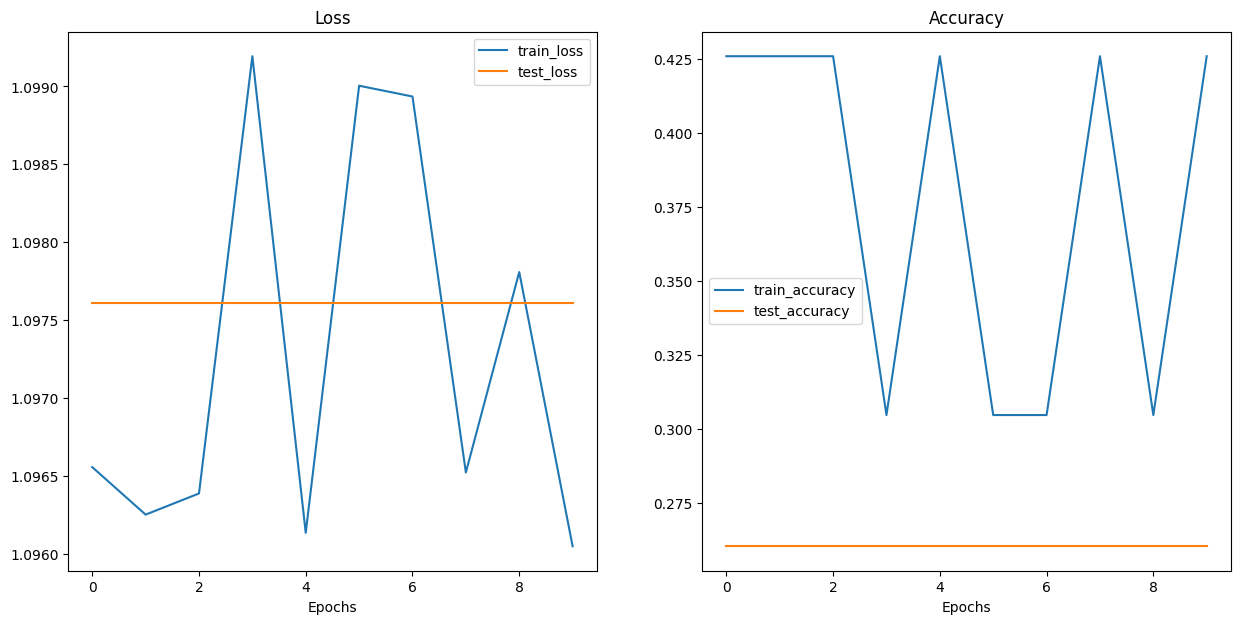

In [80]:
plot_loss_curves(results)

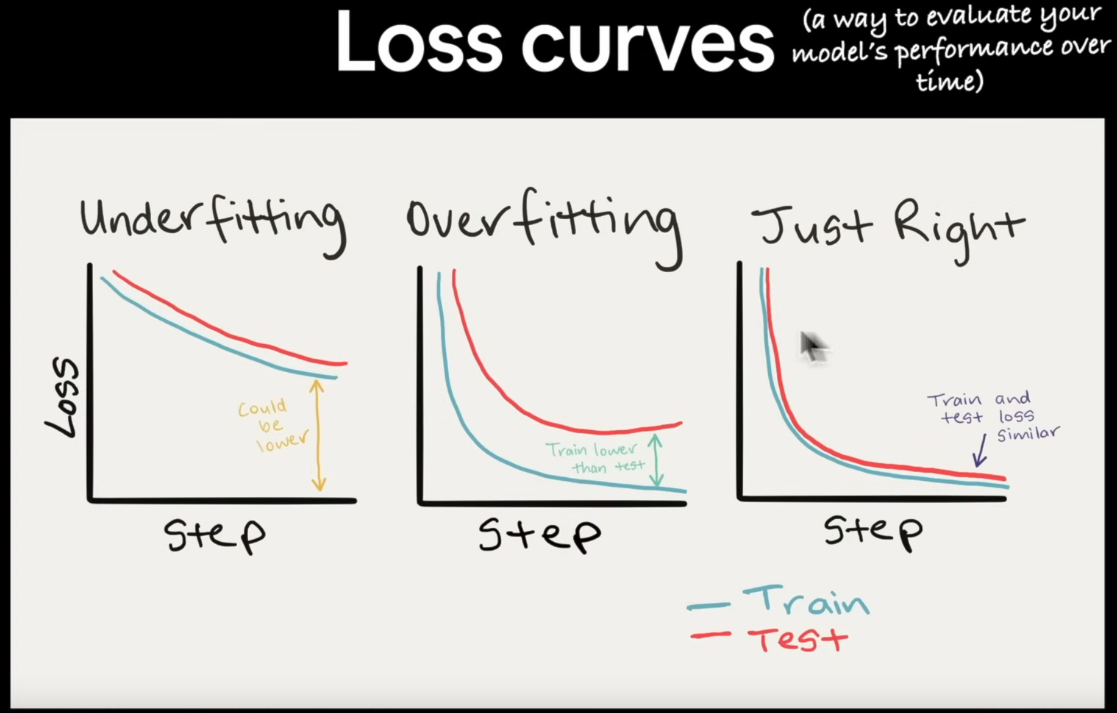

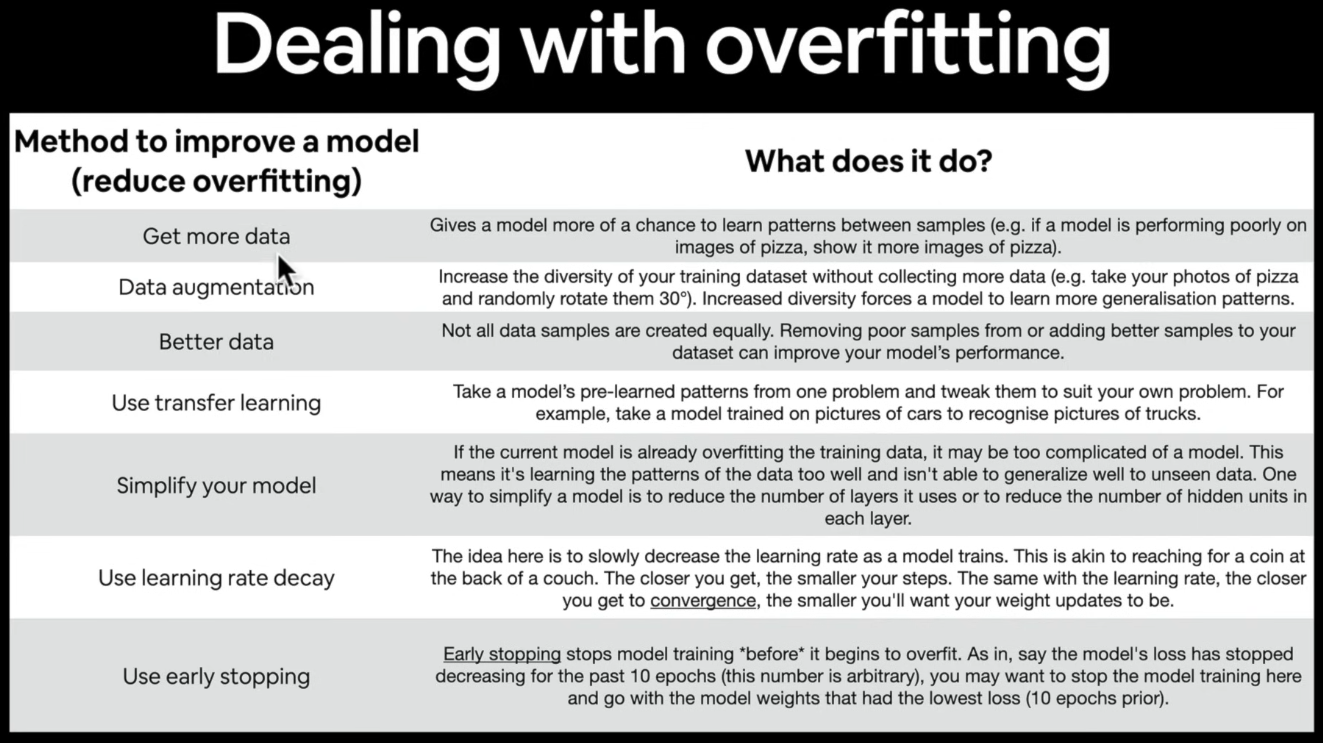

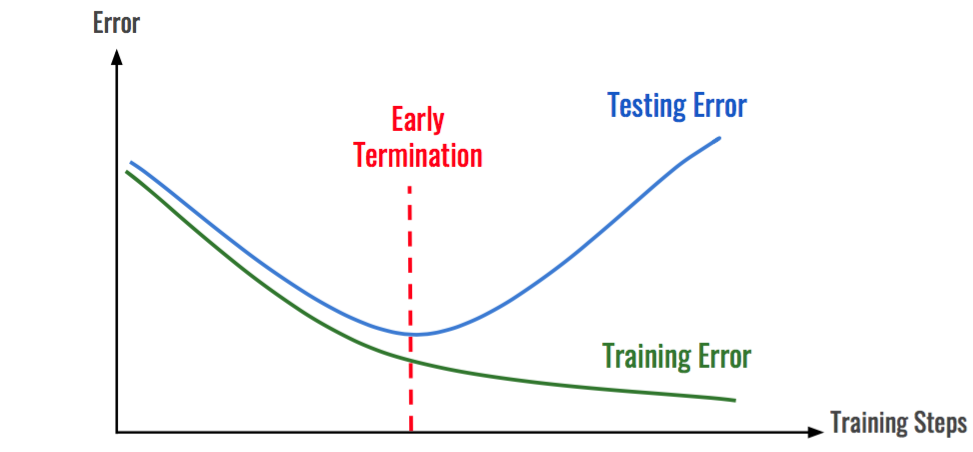

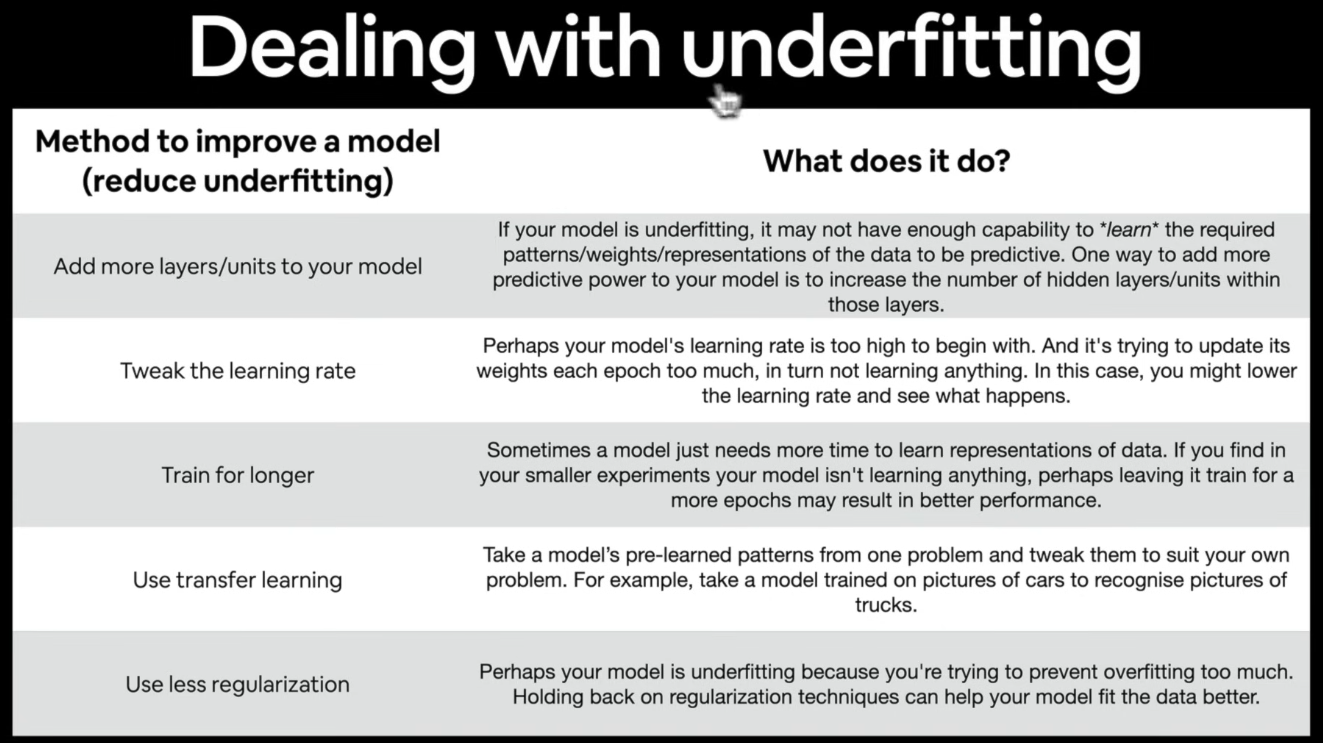

#### 9. TinyVGG with data augmentation

In [94]:
# transform with trivial augment
train_transform = transforms.Compose([
  transforms.TrivialAugmentWide(num_magnitude_bins=31),
  transforms.Resize((64, 64)),
  transforms.ToTensor()
])

test_transform = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.ToTensor()
])

In [97]:
train_dataset_augmented = ImageFolder(root=target_dir + "/train", transform=train_transform)
test_dataset_augmented = ImageFolder(root=target_dir + "/test", transform=test_transform)

train_dataloader_augmented = DataLoader(train_dataset_augmented, batch_size=32, shuffle=True)
test_dataloader_augmented = DataLoader(test_dataset_augmented, batch_size=32, shuffle=False)

In [105]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model2 = TinyVGG(
  input_shape=3,
  hidden_units=10,
  output_shape=len(train_dataloader_augmented.dataset.classes)
).to(device)
summary(model2, input_size=(32, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 30, 30]          --
│    └─Conv2d: 2-1                       [32, 10, 62, 62]          280
│    └─ReLU: 2-2                         [32, 10, 62, 62]          --
│    └─Conv2d: 2-3                       [32, 10, 60, 60]          910
│    └─ReLU: 2-4                         [32, 10, 60, 60]          --
│    └─MaxPool2d: 2-5                    [32, 10, 30, 30]          --
├─Sequential: 1-2                        [32, 10, 13, 13]          --
│    └─Conv2d: 2-6                       [32, 10, 28, 28]          910
│    └─ReLU: 2-7                         [32, 10, 28, 28]          --
│    └─Conv2d: 2-8                       [32, 10, 26, 26]          910
│    └─ReLU: 2-9                         [32, 10, 26, 26]          --
│    └─MaxPool2d: 2-10                   [32, 10, 13, 13]          --
├─Sequentia

In [102]:
epochs = 10
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss() # criterion

In [108]:
from timeit import default_timer as timer

start_time = timer()
results2 = train(model2, train_dataloader_augmented, test_dataloader_augmented, optimizer, loss_fn, epochs=epochs, device=device)
end_time = timer()
print(f"Train time on {device}: {end_time - start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | Train Loss: 1.09765 | Train Acc: 0.30% | Test Loss: 1.09507 | Test Acc: 0.48%
Epoch: 2 | Train Loss: 1.09691 | Train Acc: 0.43% | Test Loss: 1.09507 | Test Acc: 0.48%
Epoch: 3 | Train Loss: 1.09771 | Train Acc: 0.30% | Test Loss: 1.09507 | Test Acc: 0.48%
Epoch: 4 | Train Loss: 1.09918 | Train Acc: 0.30% | Test Loss: 1.09507 | Test Acc: 0.48%
Epoch: 5 | Train Loss: 1.09977 | Train Acc: 0.30% | Test Loss: 1.09507 | Test Acc: 0.48%
Epoch: 6 | Train Loss: 1.09817 | Train Acc: 0.30% | Test Loss: 1.09507 | Test Acc: 0.48%
Epoch: 7 | Train Loss: 1.09772 | Train Acc: 0.30% | Test Loss: 1.09507 | Test Acc: 0.48%
Epoch: 8 | Train Loss: 1.09690 | Train Acc: 0.43% | Test Loss: 1.09507 | Test Acc: 0.48%
Epoch: 9 | Train Loss: 1.09669 | Train Acc: 0.43% | Test Loss: 1.09507 | Test Acc: 0.48%
Epoch: 10 | Train Loss: 1.09916 | Train Acc: 0.30% | Test Loss: 1.09507 | Test Acc: 0.48%
Train time on cuda: 16.330 seconds


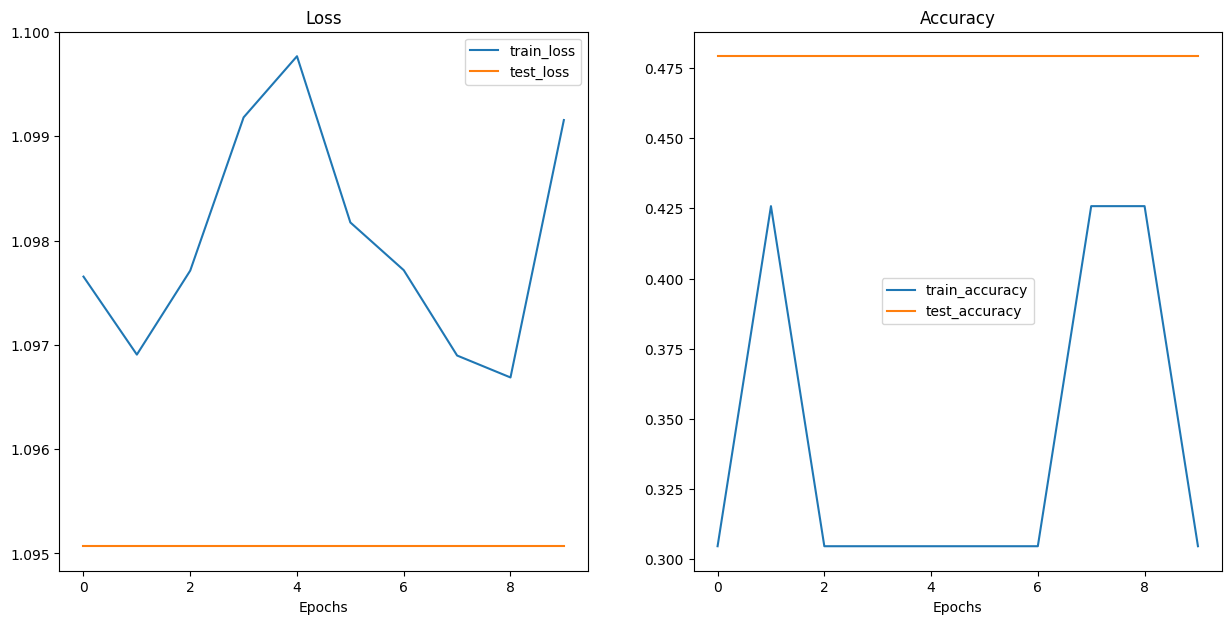

In [109]:
plot_loss_curves(results2)

#### 10. Compare model results

There's a few different ways to do this:
1. Hard coding (what we're doing)
2. PyTorch + [tensorboard](https://www.tensorflow.org/tensorboard)
3. Weights & biases library [wandb](https://wandb.ai/site)
4. MLFlow library [mlflow](https://mlflow.org/)

In [119]:
import pandas as pd

def compare_models(model_results, model2_results):
  model_0 = pd.DataFrame(model_results)
  model_1 = pd.DataFrame(model2_results)
  plt.figure(figsize=(15, 10))
  epochs = range(len(model_0))

  plt.subplot(2, 2, 1)
  plt.plot(epochs, model_0["train_loss"], label="Model 0")
  plt.plot(epochs, model_1["train_loss"], label="Model 1")
  plt.title("Train Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.subplot(2, 2, 2)
  plt.plot(epochs, model_0["test_loss"], label="Model 0")
  plt.plot(epochs, model_1["test_loss"], label="Model 1")
  plt.title("Test Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.subplot(2, 2, 3)
  plt.plot(epochs, model_0["train_acc"], label="Model 0")
  plt.plot(epochs, model_1["train_acc"], label="Model 1")
  plt.title("Train accuracy")
  plt.xlabel("Epochs")
  plt.legend()

  plt.subplot(2, 2, 4)
  plt.plot(epochs, model_0["test_acc"], label="Model 0")
  plt.plot(epochs, model_1["test_acc"], label="Model 1")
  plt.title("Test accuracy")
  plt.xlabel("Epochs")
  plt.legend()

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Train Loss: 1.09779 | Train Acc: 0.30% | Test Loss: 1.09507 | Test Acc: 0.48%
Epoch: 2 | Train Loss: 1.09640 | Train Acc: 0.43% | Test Loss: 1.09507 | Test Acc: 0.48%
Epoch: 3 | Train Loss: 1.09644 | Train Acc: 0.43% | Test Loss: 1.09507 | Test Acc: 0.48%
Epoch: 4 | Train Loss: 1.09625 | Train Acc: 0.43% | Test Loss: 1.09507 | Test Acc: 0.48%
Epoch: 5 | Train Loss: 1.09646 | Train Acc: 0.43% | Test Loss: 1.09507 | Test Acc: 0.48%


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Train Loss: 1.09693 | Train Acc: 0.43% | Test Loss: 1.09507 | Test Acc: 0.48%
Epoch: 2 | Train Loss: 1.09882 | Train Acc: 0.30% | Test Loss: 1.09507 | Test Acc: 0.48%
Epoch: 3 | Train Loss: 1.09794 | Train Acc: 0.30% | Test Loss: 1.09507 | Test Acc: 0.48%
Epoch: 4 | Train Loss: 1.09806 | Train Acc: 0.30% | Test Loss: 1.09507 | Test Acc: 0.48%
Epoch: 5 | Train Loss: 1.09670 | Train Acc: 0.43% | Test Loss: 1.09507 | Test Acc: 0.48%


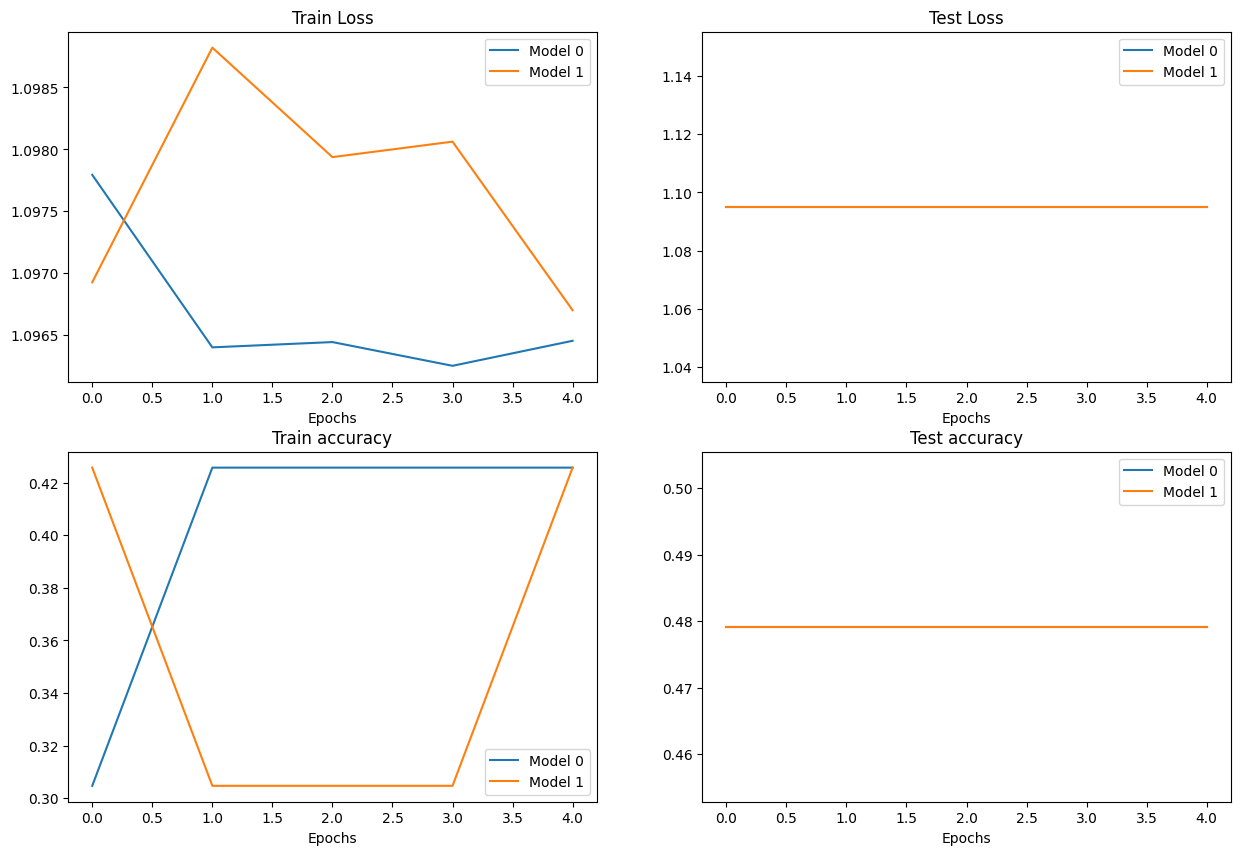

In [121]:
results1 = train(model, train_dataloader_augmented, test_dataloader_augmented, optimizer, loss_fn, epochs=5, device=device)
results2 = train(model2, train_dataloader_augmented, test_dataloader_augmented, optimizer, loss_fn, epochs=5, device=device)
compare_models(results1, results2)